## `Forecasting County-Level Acute Food Insecurity in Kenya Using Climate Shocks, Market Dynamics, Conflict Events, and Structural Poverty Indicators`

## `1. Business Understanding`

### `1.1 Problem Context`


Acute food insecurity remains a recurring challenge in Kenya, particularly in arid and semi-arid counties. Current Integrated Food Security Phase Classification (IPC) assessments provide detailed descriptions of food security conditions but are largely retrospective. As a result, humanitarian interventions are often reactive rather than anticipatory.

There is a need for a data-driven early warning system that can forecast which counties are likely to enter IPC Phase 3 (Crisis) or worse in the near future.


### `1.2 Project Objective`

To develop a spatio-temporal machine learning model that predicts whether a Kenyan county will experience acute food insecurity `(IPC ≥ 3)` in the following month, using:

- Climate indicators (rainfall anomalies)

- Market indicators (food prices)

- Conflict events

- Structural vulnerability (MPI)


### `1.3 Business Value`

The model supports:

- Humanitarian agencies (WFP, FAO, NGOs)

- County governments

- National drought management authorities

- Policy planners


By forecasting crisis risk early, stakeholders can:

- Prioritize resource allocation

- Trigger anticipatory action

- Improve efficiency of emergency response

### `2. Data Understanding`

The project uses five datasets:

### `2.1 IPC Dataset (Target Variable)`

Purpose: Defines food insecurity classification.

Key Variable:

- IPC Phase (1–5)

Target Definition:

Binary target:
- 1 → IPC ≥ 3 (Crisis or worse)
- 0 → IPC < 3

Time Structure:

- County-level

- Periodic assessments

Role:

- Supervised learning target (shifted to t+1 for forecasting)


### `2.2 Rainfall Dataset`

Purpose: Captures climate shocks.

Key Variables:

- Monthly rainfall

- Rainfall anomaly

Role:

- Predictor of agricultural stress

- Lagged effects (t-1, t-2)


### `2.3 Food Prices Dataset (WFP)`

Purpose: Captures market stress.

Key Variables:

- Commodity

- USD price

- Market location

- Date

Processing:

- Aggregated to county-month

- Staple price index constructed

- Monthly price change computed

Role:

- Short-term shock indicator


### `2.4 Conflict Dataset`

Purpose: Captures instability and displacement risk.

Key Variables:

- Fatalities




### `2.5 MPI Dataset (Structural Poverty)`

Purpose: Captures long-term vulnerability.

Key Variables:

- Multidimensional Poverty Index score

- Possibly deprivation indicators

Role:

- Static vulnerability factor

- Moderates shock effects

## 3. Data Prepatation

In [1]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Date handling
from datetime import datetime

# Warnings
import warnings
warnings.filterwarnings("ignore")

# For geospatial (later)
# import geopandas as gpd

print("Libraries imported successfully.")


Libraries imported successfully.


In [2]:
# IPC dataset
ipc = pd.read_csv("../data/ipc_ken_area_long.csv")

# Rainfall dataset
rain = pd.read_csv("../data/ken-rainfall-subnat-full.csv")

# Conflict dataset
conflict = pd.read_excel("../data/kenya_political_violence_events_and_fatalities_by_month-year_as-of-11feb2026.xlsx")

# MPI dataset
mpi = pd.read_csv("../data/ken_mpi.csv")

# Food Prices dataset
prices = pd.read_csv("../data/wfp_food_prices_ken.csv")

print("All datasets loaded.")


All datasets loaded.


## A. IPC Data Preparation

In [3]:
ipc.head()

,Date of analysis,Country,Total country population,Level 1,Area,Validity period,From,To,Phase,Number,Percentage
0,Jul 2025,KEN,16617000,Others,Marsabit,current,2025-07-01,2025-09-30,all,515000,1.00
1,Jul 2025,KEN,16617000,Others,Marsabit,current,2025-07-01,2025-09-30,3+,103000,0.20
2,Jul 2025,KEN,16617000,Others,Marsabit,current,2025-07-01,2025-09-30,1,128750,0.25
3,Jul 2025,KEN,16617000,Others,Marsabit,current,2025-07-01,2025-09-30,2,283250,0.55
4,Jul 2025,KEN,16617000,Others,Marsabit,current,2025-07-01,2025-09-30,3,103000,0.20


In [4]:
# Create ipc_pivot from ipc
ipc_pivot = ipc.pivot_table(values='Percentage', index=['Area', 'From'], columns='Phase', fill_value=0).reset_index()
ipc_pivot['target_ipc3plus_pct'] = ipc_pivot['3+']

### A.1. IPC Target Preparation

In [5]:
# Create Classification Target (binary)
# Threshold can be adjusted (0.10 = 10% population in crisis)
ipc_pivot['target_crisis_binary'] = (
    ipc_pivot['target_ipc3plus_pct'] > 0.10
).astype(int)

### A.2. Drop Bangladesh

In [6]:
ipc_pivot = ipc_pivot.drop(ipc_pivot.index[0] )
ipc_pivot.head()

Phase,Area,From,1,2,3,3+,4,5,all,target_ipc3plus_pct,target_crisis_binary
1,BANGLADESH,2020-10-01,0.10,0.40,0.45,0.50,0.05,0.0,1.0,0.50,1
2,Baringo,2019-07-01,0.35,0.50,0.10,0.15,0.05,0.0,1.0,0.15,1
3,Baringo,2019-08-01,0.30,0.50,0.15,0.20,0.05,0.0,1.0,0.20,1
4,Baringo,2020-02-01,0.70,0.25,0.05,0.05,0.00,0.0,1.0,0.05,0
5,Baringo,2020-04-01,0.85,0.15,0.00,0.00,0.00,0.0,1.0,0.00,0


### A.3. Histogram of IPC 3+ Percentage
`This shows how food insecurity is distributed across counties and time.`

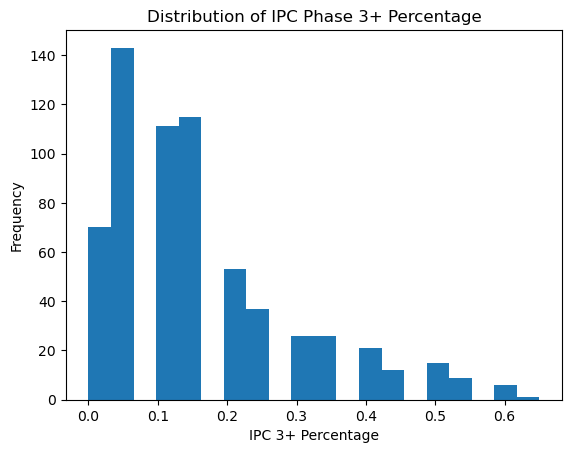

In [7]:
plt.figure()
plt.hist(ipc_pivot['target_ipc3plus_pct'], bins=20)
plt.title("Distribution of IPC Phase 3+ Percentage")
plt.xlabel("IPC 3+ Percentage")
plt.ylabel("Frequency")
plt.show()

### A.4. Crisis vs Non-Crisis Bar Chart
`This confirms your 79% vs 21% imbalance visually.`

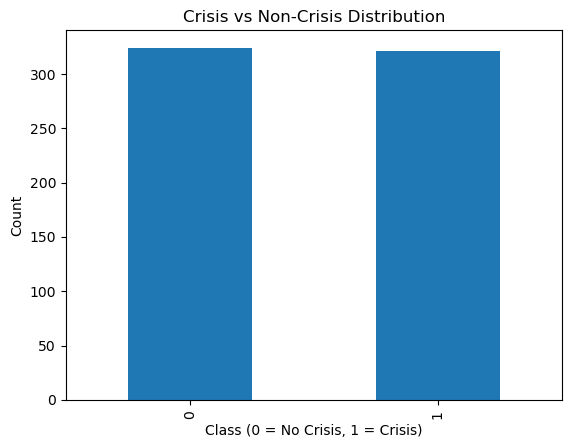

In [8]:
plt.figure()
ipc_pivot['target_crisis_binary'].value_counts().plot(kind='bar')
plt.title("Crisis vs Non-Crisis Distribution")
plt.xlabel("Class (0 = No Crisis, 1 = Crisis)")
plt.ylabel("Count")
plt.show()

### A.5. Trend Over Time

`Drought spikes`

`Recovery periods`

`Long-term trends`

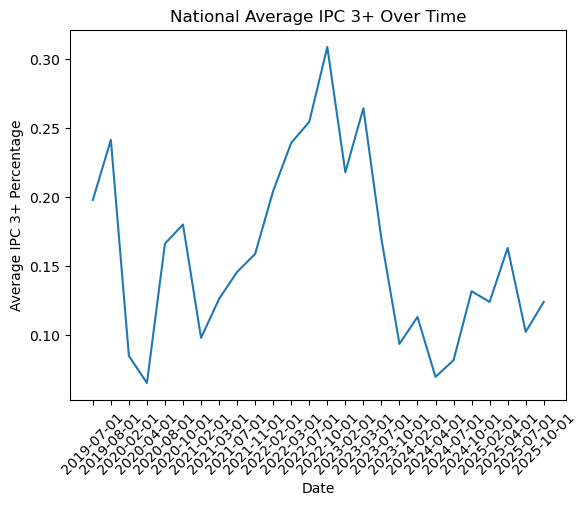

In [9]:
ipc_trend = ipc_pivot.groupby('From')['target_ipc3plus_pct'].mean()

plt.figure()
plt.plot(ipc_trend.index, ipc_trend.values)
plt.title("National Average IPC 3+ Over Time")
plt.xlabel("Date")
plt.ylabel("Average IPC 3+ Percentage")
plt.xticks(rotation=45)
plt.show()

### A.6. Top 10 Counties by Average IPC 3+

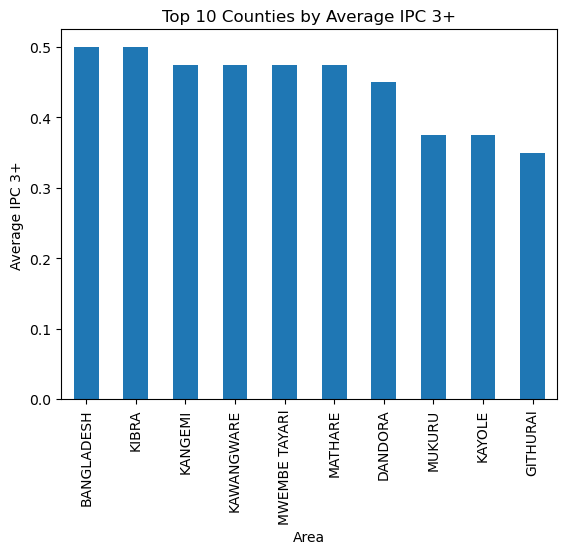

In [10]:
top_counties = (
    ipc_pivot.groupby('Area')['target_ipc3plus_pct']
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure()
top_counties.plot(kind='bar')
plt.title("Top 10 Counties by Average IPC 3+")
plt.ylabel("Average IPC 3+")
plt.show()

In [11]:
print(ipc_pivot.shape)
print(ipc_pivot['Area'].nunique())
print(ipc_pivot['From'].min(), "to", ipc_pivot['From'].max())

(645, 11)
54
2019-07-01 to 2025-10-01


## B. RAIN Data Preparation

In [12]:
rain.head()

,date,adm_level,adm_id,PCODE,n_pixels,rfh,rfh_avg,r1h,r1h_avg,r3h,r3h_avg,rfq,r1q,r3q,version
0,1981-01-01,1,51325,KE019,427.0,7.372365,15.759407,NaN,NaN,NaN,NaN,59.598840,NaN,NaN,final
1,1981-01-11,1,51325,KE019,427.0,4.325527,19.294770,NaN,NaN,NaN,NaN,38.384920,NaN,NaN,final
2,1981-01-21,1,51325,KE019,427.0,5.569087,16.265417,17.266980,51.319595,NaN,NaN,49.700817,39.536823,NaN,final
3,1981-02-01,1,51325,KE019,427.0,5.882904,12.719282,15.777517,48.279470,NaN,NaN,61.418427,38.997230,NaN,final
4,1981-02-11,1,51325,KE019,427.0,17.180328,18.768618,28.632318,47.753320,NaN,NaN,93.317700,63.753933,NaN,final


In [13]:
print(rain.head())
print(rain.columns)
print(rain.shape)

         date  adm_level  adm_id  PCODE  n_pixels        rfh    rfh_avg  \
0  1981-01-01          1   51325  KE019     427.0   7.372365  15.759407   
1  1981-01-11          1   51325  KE019     427.0   4.325527  19.294770   
2  1981-01-21          1   51325  KE019     427.0   5.569087  16.265417   
3  1981-02-01          1   51325  KE019     427.0   5.882904  12.719282   
4  1981-02-11          1   51325  KE019     427.0  17.180328  18.768618   

         r1h    r1h_avg  r3h  r3h_avg        rfq        r1q  r3q version  
0        NaN        NaN  NaN      NaN  59.598840        NaN  NaN   final  
1        NaN        NaN  NaN      NaN  38.384920        NaN  NaN   final  
2  17.266980  51.319595  NaN      NaN  49.700817  39.536823  NaN   final  
3  15.777517  48.279470  NaN      NaN  61.418427  38.997230  NaN   final  
4  28.632318  47.753320  NaN      NaN  93.317700  63.753933  NaN   final  
Index(['date', 'adm_level', 'adm_id', 'PCODE', 'n_pixels', 'rfh', 'rfh_avg',
       'r1h', 'r1h_avg

### B.1. converting to monthly Rainfall

In [14]:
# Convert date
rain['date'] = pd.to_datetime(rain['date'])

# Convert to monthly timestamp
rain['From'] = rain['date'].dt.to_period('M').dt.to_timestamp()

# Aggregate to monthly rainfall per PCODE
rain_monthly = (
    rain.groupby(['PCODE', 'From'])['rfh']
    .sum()
    .reset_index()
)

rain_monthly.rename(columns={'rfh': 'rain_mm'}, inplace=True)

print(rain_monthly.head())

      PCODE       From  rain_mm
0  KE001003 1981-01-01     32.0
1  KE001003 1981-02-01      7.2
2  KE001003 1981-03-01    166.4
3  KE001003 1981-04-01     96.8
4  KE001003 1981-05-01    153.1


### B.2. Restrict to IPC Date Range
`ipc ranges from 2019-07 to 2025-07`

In [15]:
rain_monthly = rain_monthly[
    (rain_monthly['From'] >= ipc_pivot['From'].min()) &
    (rain_monthly['From'] <= ipc_pivot['From'].max())
]
rain_monthly.head()

,PCODE,From,rain_mm
462,KE001003,2019-07-01,103.7
463,KE001003,2019-08-01,80.3
464,KE001003,2019-09-01,88.4
465,KE001003,2019-10-01,442.9
466,KE001003,2019-11-01,184.1


### B.3. Map PCODE → County Name & Merge with IPC

In [16]:
print(rain_monthly['PCODE'].nunique())

81


In [17]:
# Monthly rainfall 

# Aggregate nationally
rain_national = (
    rain_monthly.groupby('From')['rain_mm']
    .mean()
    .reset_index()
)

# Create lag
rain_national['rain_lag1'] = rain_national['rain_mm'].shift(1)

# Convert ipc_pivot From to datetime for merge
ipc_pivot['From'] = pd.to_datetime(ipc_pivot['From'])

# Merge with IPC
data = ipc_pivot.merge(
    rain_national[['From','rain_lag1']],
    on='From',
    how='left'
)

print(data.head())

         Area       From     1     2     3    3+     4    5  all  \
0  BANGLADESH 2020-10-01  0.10  0.40  0.45  0.50  0.05  0.0  1.0   
1     Baringo 2019-07-01  0.35  0.50  0.10  0.15  0.05  0.0  1.0   
2     Baringo 2019-08-01  0.30  0.50  0.15  0.20  0.05  0.0  1.0   
3     Baringo 2020-02-01  0.70  0.25  0.05  0.05  0.00  0.0  1.0   
4     Baringo 2020-04-01  0.85  0.15  0.00  0.00  0.00  0.0  1.0   

   target_ipc3plus_pct  target_crisis_binary   rain_lag1  
0                 0.50                     1   97.032278  
1                 0.15                     1         NaN  
2                 0.20                     1   75.850663  
3                 0.05                     0   97.332460  
4                 0.00                     0  202.546872  


`IPC target (regression + binary)`

`Rainfall lagged`

`Proper time alignment`

`Only first row NaN (expected due to lag)`

### B.4. Merged IPC & RAIN 

In [18]:
data.head()

,Area,From,1,2,3,3+,4,5,all,target_ipc3plus_pct,target_crisis_binary,rain_lag1
0,BANGLADESH,2020-10-01,0.10,0.40,0.45,0.50,0.05,0.0,1.0,0.50,1,97.032278
1,Baringo,2019-07-01,0.35,0.50,0.10,0.15,0.05,0.0,1.0,0.15,1,NaN
2,Baringo,2019-08-01,0.30,0.50,0.15,0.20,0.05,0.0,1.0,0.20,1,75.850663
3,Baringo,2020-02-01,0.70,0.25,0.05,0.05,0.00,0.0,1.0,0.05,0,97.332460
4,Baringo,2020-04-01,0.85,0.15,0.00,0.00,0.00,0.0,1.0,0.00,0,202.546872


## C. PRICES Data Preparation

In [19]:
prices.head()

,date,admin1,admin2,market,market_id,latitude,longitude,category,commodity,commodity_id,unit,priceflag,pricetype,currency,price,usdprice
0,#date,#adm1+name,#adm2+name,#loc+market+name,#loc+market+code,#geo+lat,#geo+lon,#item+type,#item+name,#item+code,#item+unit,#item+price+flag,#item+price+type,#currency+code,#value,#value+usd
1,2006-01-15,Coast,Mombasa,Mombasa,191,-4.05,39.67,cereals and tubers,Maize,51,KG,actual,Wholesale,KES,16.13,0.22
2,2006-01-15,Coast,Mombasa,Mombasa,191,-4.05,39.67,cereals and tubers,Maize (white),67,90 KG,actual,Wholesale,KES,1480,20.58
3,2006-01-15,Coast,Mombasa,Mombasa,191,-4.05,39.67,pulses and nuts,Beans,50,KG,actual,Wholesale,KES,33.63,0.47
4,2006-01-15,Eastern,Kitui,Kitui,187,-1.37,38.02,cereals and tubers,Maize (white),67,KG,actual,Retail,KES,17,0.24


In [20]:
print(prices.shape)

(17365, 16)


### C.1. Rebuilding price_monthly at COUNTY level + Merging

In [21]:
# 1. Rebuild price_monthly at COUNTY level

# Ensure clean types
prices['date'] = pd.to_datetime(prices['date'], errors='coerce')
prices['usdprice'] = pd.to_numeric(prices['usdprice'], errors='coerce')

prices = prices.dropna(subset=['date','usdprice'])

# Create monthly key
prices['From'] = prices['date'].dt.to_period('M').dt.to_timestamp()

# Aggregate at COUNTY level (admin2)
price_monthly = (
    prices.groupby(['admin2','From'])['usdprice']
    .mean()
    .reset_index()
)

# Rename admin2 to Area so it matches IPC dataset
price_monthly = price_monthly.rename(columns={'admin2':'Area'})

# Clean names
price_monthly['Area'] = price_monthly['Area'].str.strip()
data['Area'] = data['Area'].str.strip()


# 2. Merge into existing IPC+rain data


data['From'] = pd.to_datetime(data['From'])
price_monthly['From'] = pd.to_datetime(price_monthly['From'])

data = data.merge(
    price_monthly,
    on=['Area','From'],
    how='left'
)

print("Final shape:", data.shape)
print(data[['Area','From','usdprice']].head())

Final shape: (645, 13)
         Area       From  usdprice
0  BANGLADESH 2020-10-01       NaN
1     Baringo 2019-07-01     0.540
2     Baringo 2019-08-01     1.220
3     Baringo 2020-02-01     0.785
4     Baringo 2020-04-01     0.815


### C.2. Merged IPC + RAIN + FOOD PRICES

In [22]:
data.head()

,Area,From,1,2,3,3+,4,5,all,target_ipc3plus_pct,target_crisis_binary,rain_lag1,usdprice
0,BANGLADESH,2020-10-01,0.10,0.40,0.45,0.50,0.05,0.0,1.0,0.50,1,97.032278,NaN
1,Baringo,2019-07-01,0.35,0.50,0.10,0.15,0.05,0.0,1.0,0.15,1,NaN,0.540
2,Baringo,2019-08-01,0.30,0.50,0.15,0.20,0.05,0.0,1.0,0.20,1,75.850663,1.220
3,Baringo,2020-02-01,0.70,0.25,0.05,0.05,0.00,0.0,1.0,0.05,0,97.332460,0.785
4,Baringo,2020-04-01,0.85,0.15,0.00,0.00,0.00,0.0,1.0,0.00,0,202.546872,0.815


### C.3. Checking Correlation

In [23]:
data[['rain_lag1','usdprice','target_ipc3plus_pct']].corr()

,rain_lag1,usdprice,target_ipc3plus_pct
rain_lag1,1.000000,-0.353201,-0.144677
usdprice,-0.353201,1.000000,0.062603
target_ipc3plus_pct,-0.144677,0.062603,1.000000


### C.4. Rainfall → Prices

rain_lag1 vs usdprice = `-0.36`

`This is a moderate negative correlation.`

Interpretation:

`When rainfall increases, food prices tend to decrease.`

This makes economic sense:

`More rain → better harvest → more supply → lower prices.`

## D. CONFLICT Data Preparation

`This dataset will be dropped its not useful`

In [24]:
conflict.head(10)

,Licensing
0,By using ACLED data you agree to abide by the ...
1,https://acleddata.com/terms-of-use/
2,NaN
3,Terms of Use
4,All rights to use or exploit ACLED data or ana...
5,No user is permitted to (i) use ACLED’s data o...
6,If you wish to use ACLED data in your own data...
7,Crawling the ACLED website or API is allowed i...


### E. MPI Data Preparation

In [25]:
mpi.head()

,Country ISO3,Admin 1 PCode,Admin 1 Name,MPI,Headcount Ratio,Intensity of Deprivation,Vulnerable to Poverty,In Severe Poverty,Survey,Start Date,End Date
0,#country+code,#adm1+code,#adm1+name,#indicator+mpi,#indicator+headcount_ratio,#indicator+intensity_of_deprivation,#indicator+vulnerable_to_poverty,#indicator+in_severe_poverty,#meta+survey,#date+start,#date+end
1,KEN,NaN,NaN,0.1134,25.3523,44.7108,26.4044,7.4594,DHS,2022-01-01 00:00:00+00:00,2022-12-31 23:59:59+00:00
2,KEN,KE001,Mombasa,0.0518,12.8866,40.2193,16.8930,2.2801,DHS,2022-01-01 00:00:00+00:00,2022-12-31 23:59:59+00:00
3,KEN,KE002,Kwale,0.2105,44.5123,47.2996,27.2794,17.2902,DHS,2022-01-01 00:00:00+00:00,2022-12-31 23:59:59+00:00
4,KEN,KE003,Kilifi,0.2026,46.3581,43.7119,23.8772,13.1869,DHS,2022-01-01 00:00:00+00:00,2022-12-31 23:59:59+00:00


In [26]:
# 1. CLEAN MPI DATA


# Remove metadata row (row containing #)
mpi_clean = mpi[~mpi["Country ISO3"].astype(str).str.contains("#")].copy()

# Remove national aggregate row (Admin 1 Name is NaN)
mpi_clean = mpi_clean[mpi_clean["Admin 1 Name"].notna()].copy()

# Keep only relevant columns
mpi_clean = mpi_clean[[
    "Admin 1 Name",
    "MPI",
    "Headcount Ratio",
    "Intensity of Deprivation",
    "Vulnerable to Poverty",
    "In Severe Poverty"
]].copy()

# Rename column to match main dataset
mpi_clean.rename(columns={"Admin 1 Name": "Area"}, inplace=True)

# Clean Area names
mpi_clean["Area"] = mpi_clean["Area"].astype(str).str.strip()

# Convert numeric columns
num_cols = mpi_clean.columns.drop("Area")
mpi_clean[num_cols] = mpi_clean[num_cols].apply(pd.to_numeric, errors="coerce")

print("MPI cleaned shape:", mpi_clean.shape)



# 2. CLEAN MAIN DATASET

data["Area"] = data["Area"].astype(str).str.strip()



# 3. MERGE MPI INTO data

data = data.merge(mpi_clean, on="Area", how="left")

print("Final shape after MPI merge:", data.shape)
print(data.head())



# 4. CHECK UNMATCHED AREAS


missing = data[data["MPI"].isna()]["Area"].unique()

print("Rows missing MPI:", data["MPI"].isna().sum())
print("Unmatched Areas:", missing)

MPI cleaned shape: (47, 6)
Final shape after MPI merge: (645, 18)
         Area       From     1     2     3    3+     4    5  all  \
0  BANGLADESH 2020-10-01  0.10  0.40  0.45  0.50  0.05  0.0  1.0   
1     Baringo 2019-07-01  0.35  0.50  0.10  0.15  0.05  0.0  1.0   
2     Baringo 2019-08-01  0.30  0.50  0.15  0.20  0.05  0.0  1.0   
3     Baringo 2020-02-01  0.70  0.25  0.05  0.05  0.00  0.0  1.0   
4     Baringo 2020-04-01  0.85  0.15  0.00  0.00  0.00  0.0  1.0   

   target_ipc3plus_pct  target_crisis_binary   rain_lag1  usdprice     MPI  \
0                 0.50                     1   97.032278       NaN     NaN   
1                 0.15                     1         NaN     0.540  0.2159   
2                 0.20                     1   75.850663     1.220  0.2159   
3                 0.05                     0   97.332460     0.785  0.2159   
4                 0.00                     0  202.546872     0.815  0.2159   

   Headcount Ratio  Intensity of Deprivation  Vulnerable

In [27]:
data.head()

,Area,From,1,2,3,3+,4,5,all,target_ipc3plus_pct,target_crisis_binary,rain_lag1,usdprice,MPI,Headcount Ratio,Intensity of Deprivation,Vulnerable to Poverty,In Severe Poverty
0,BANGLADESH,2020-10-01,0.10,0.40,0.45,0.50,0.05,0.0,1.0,0.50,1,97.032278,NaN,NaN,NaN,NaN,NaN,NaN
1,Baringo,2019-07-01,0.35,0.50,0.10,0.15,0.05,0.0,1.0,0.15,1,NaN,0.540,0.2159,46.8917,46.0451,25.6884,17.5521
2,Baringo,2019-08-01,0.30,0.50,0.15,0.20,0.05,0.0,1.0,0.20,1,75.850663,1.220,0.2159,46.8917,46.0451,25.6884,17.5521
3,Baringo,2020-02-01,0.70,0.25,0.05,0.05,0.00,0.0,1.0,0.05,0,97.332460,0.785,0.2159,46.8917,46.0451,25.6884,17.5521
4,Baringo,2020-04-01,0.85,0.15,0.00,0.00,0.00,0.0,1.0,0.00,0,202.546872,0.815,0.2159,46.8917,46.0451,25.6884,17.5521


In [28]:
data.isna().sum()

Area                          0
From                          0
1                             0
2                             0
3                             0
3+                            0
4                             0
5                             0
all                           0
target_ipc3plus_pct           0
target_crisis_binary          0
rain_lag1                    23
usdprice                    508
MPI                         171
Headcount Ratio             171
Intensity of Deprivation    171
Vulnerable to Poverty       171
In Severe Poverty           171
dtype: int64

In [29]:
data[['rain_lag1','usdprice',"MPI",
    "Headcount Ratio",
    "Intensity of Deprivation",
    "Vulnerable to Poverty",
    "In Severe Poverty",
    "target_ipc3plus_pct"]].corr()

,rain_lag1,usdprice,MPI,Headcount Ratio,Intensity of Deprivation,Vulnerable to Poverty,In Severe Poverty,target_ipc3plus_pct
rain_lag1,1.000000,-0.353201,0.036695,0.036847,0.042521,-0.029874,0.036367,-0.144677
usdprice,-0.353201,1.000000,-0.266210,-0.239172,-0.330104,0.179440,-0.278221,0.062603
MPI,0.036695,-0.266210,1.000000,0.986783,0.931696,-0.632809,0.983445,0.573090
Headcount Ratio,0.036847,-0.239172,0.986783,1.000000,0.881507,-0.539998,0.942605,0.558687
Intensity of Deprivation,0.042521,-0.330104,0.931696,0.881507,1.000000,-0.739073,0.962424,0.561608
Vulnerable to Poverty,-0.029874,0.179440,-0.632809,-0.539998,-0.739073,1.000000,-0.732824,-0.412847
In Severe Poverty,0.036367,-0.278221,0.983445,0.942605,0.962424,-0.732824,1.000000,0.578844
target_ipc3plus_pct,-0.144677,0.062603,0.573090,0.558687,0.561608,-0.412847,0.578844,1.000000


In [30]:
data.dropna(subset=['In Severe Poverty'], inplace=True)
data.isna().sum()

Area                          0
From                          0
1                             0
2                             0
3                             0
3+                            0
4                             0
5                             0
all                           0
target_ipc3plus_pct           0
target_crisis_binary          0
rain_lag1                    18
usdprice                    337
MPI                           0
Headcount Ratio               0
Intensity of Deprivation      0
Vulnerable to Poverty         0
In Severe Poverty             0
dtype: int64

In [31]:
data.dropna(subset=['rain_lag1','usdprice',], inplace=True)
data.isna().sum()

Area                        0
From                        0
1                           0
2                           0
3                           0
3+                          0
4                           0
5                           0
all                         0
target_ipc3plus_pct         0
target_crisis_binary        0
rain_lag1                   0
usdprice                    0
MPI                         0
Headcount Ratio             0
Intensity of Deprivation    0
Vulnerable to Poverty       0
In Severe Poverty           0
dtype: int64

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

# Ensure date format
data["From"] = pd.to_datetime(data["From"])

# Drop first rain lag missing rows
data = data.dropna(subset=["rain_lag1"]).copy()


# FEATURES (no leakage variables)

features = [
    "rain_lag1",
    "usdprice",
    "MPI",
    "Headcount Ratio",
    "Intensity of Deprivation",
    "Vulnerable to Poverty",
    "In Severe Poverty"
]

X = data[features]
y = data["target_crisis_binary"]

### Time based Split

In [33]:
train = data[data["From"] < "2021-01-01"]
test  = data[data["From"] >= "2021-01-01"]

print("Train size:", train.shape)
print("Test size:", test.shape)

# Check again
print("Train NaNs:")
print(train[features].isna().sum())

print("Test NaNs:")
print(test[features].isna().sum())

Train size: (27, 18)
Test size: (105, 18)
Train NaNs:
rain_lag1                   0
usdprice                    0
MPI                         0
Headcount Ratio             0
Intensity of Deprivation    0
Vulnerable to Poverty       0
In Severe Poverty           0
dtype: int64
Test NaNs:
rain_lag1                   0
usdprice                    0
MPI                         0
Headcount Ratio             0
Intensity of Deprivation    0
Vulnerable to Poverty       0
In Severe Poverty           0
dtype: int64


## MODEL 1 — Logistic Regression (Baseline)

In [34]:
X_train = train[features]
y_train = train["target_crisis_binary"]

X_test = test[features]
y_test = test["target_crisis_binary"]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)

log_model.fit(X_train_scaled, y_train)

pred = log_model.predict(X_test_scaled)

print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print("ROC AUC:", roc_auc_score(y_test, log_model.predict_proba(X_test_scaled)[:,1]))

[[14 20]
 [ 8 63]]
              precision    recall  f1-score   support

           0       0.64      0.41      0.50        34
           1       0.76      0.89      0.82        71

    accuracy                           0.73       105
   macro avg       0.70      0.65      0.66       105
weighted avg       0.72      0.73      0.72       105

ROC AUC: 0.7543496271748137


` 1 Confusion matrix:`

[[20  0]

 [34  3]]

- 20 → Correctly predicted NO crisis

- 0 → False alarms

- 34 → Missed crises ❌

- 3 → Correctly detected crises


`2 Problem`

Recall (crisis class = 1) = 0.08

That is extremely low.

- The model is failing to detect crises.

It is playing safe:

- It predicts mostly `“no crisis”`

-When it predicts crisis, it is correct (precision = 1.00)

- But it almost never predicts crisis


`3 ROC AUC = 0.65`

That means:

- Model has some signal

- But linear relationship (Logistic Regression) is too weak


`4 Conclusion`

- Logistic Regression is not powerful enough for this nonlinear problem.

Crisis formation is likely:

- Nonlinear

- Interaction-driven (rain × poverty × price)

We move to a stronger model.

## MODEL 2 — Random Forest (Nonlinear)

In [35]:
rf_model = RandomForestClassifier(
    n_estimators=400,
    max_depth=8,
    class_weight="balanced",
    random_state=42
)

rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)

print(confusion_matrix(y_test, rf_pred))
print(classification_report(y_test, rf_pred))
print("ROC AUC:", roc_auc_score(y_test, rf_model.predict_proba(X_test)[:,1]))

[[ 8 26]
 [10 61]]
              precision    recall  f1-score   support

           0       0.44      0.24      0.31        34
           1       0.70      0.86      0.77        71

    accuracy                           0.66       105
   macro avg       0.57      0.55      0.54       105
weighted avg       0.62      0.66      0.62       105

ROC AUC: 0.6936619718309859


In [39]:
data.to_csv("cleaned_dataset.csv", index=False)

In [36]:
import joblib

# Save model
joblib.dump(rf_model, "rf_model.pkl")

# Save scaler (if using logistic)
joblib.dump(scaler, "scaler.pkl")

print("Model saved successfully.")

Model saved successfully.


In [37]:
import sklearn
print(sklearn.__version__)

1.6.1


In [38]:
import sys
print(sys.version)

3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 16:37:03) [MSC v.1929 64 bit (AMD64)]
